<a href="https://colab.research.google.com/github/DarioCarolla/Time-Series-Analysis/blob/master/SDMTAS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Streaming Data Management and Time Series Analysis Project**

### *Dario Carolla Mat. 807547*

## Librerie

Importazioni delle librerie necessarie

In [96]:
# general library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

# ARIMA model
import statsmodels.tsa.statespace.sarimax as sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays

import statsmodels.api as sm

Mount per l'utilizzo di Google Drive

In [97]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Caricamento dei dati

In [3]:
# Path Google Drive
data_path = '/content/drive/My Drive/SDMTAS_Project/time_series_dataset.csv'
# Read data
df = pd.read_csv(data_path, sep = ';')

## Data Analysis

In [4]:
def print_bold(string):
  bold = '\033[1m'
  stop_bold = '\033[0m'
  print(bold + string + stop_bold)

print_bold('Head del dataset:')
print(df.head())
print()
print('--------------------------')
print()
print_bold('Informazioni sul dataset:')
print(df.info())

Head del dataset:
         Data       value
0  2010-01-01   41.651044
1  2010-01-02  131.286604
2  2010-01-03  117.388117
3  2010-01-04  116.461280
4  2010-01-05  123.823765

--------------------------

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    3287 non-null   object 
 1   value   3287 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.5+ KB
None


Il dataset è costituito da due colonne:
*   Data: rappresenta il momento in cui è stato rilevato il valore. (Necessita la trasformazione di Date-Time)
*   value: rappresenta il valore dei prezzi del mercato energetico.

Sono presenti 3287 valori e non sono presenti valori nulli.

Trasformazione in datetime di *Data*

In [5]:
df.Data = pd.to_datetime(df.Data)
df.dtypes

Data     datetime64[ns]
value           float64
dtype: object

In [6]:
print("La serie storica parte da " + str(min(df.Data)) + " e termina il " + str(max(df.Data)))

La serie storica parte da 2010-01-01 00:00:00 e termina il 2018-12-31 00:00:00


Ricerca di eventuali giorni duplicati

In [7]:
df[df['Data'].duplicated()]

,Data,value


In [8]:
df = df.set_index('Data')

Rappresentazione grafica della serie storica

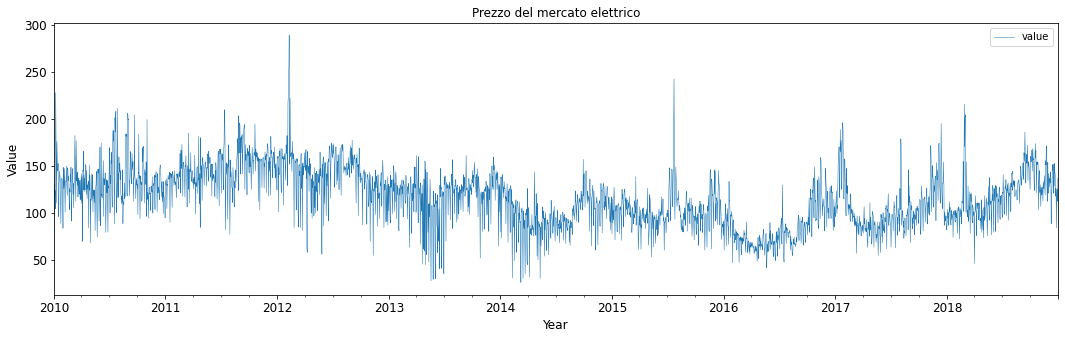

In [9]:
df.plot(figsize=(18,5), linewidth=0.5, fontsize=12)
plt.title('Prezzo del mercato elettrico')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12);

Si osseva i diversi elementi della serie storica

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


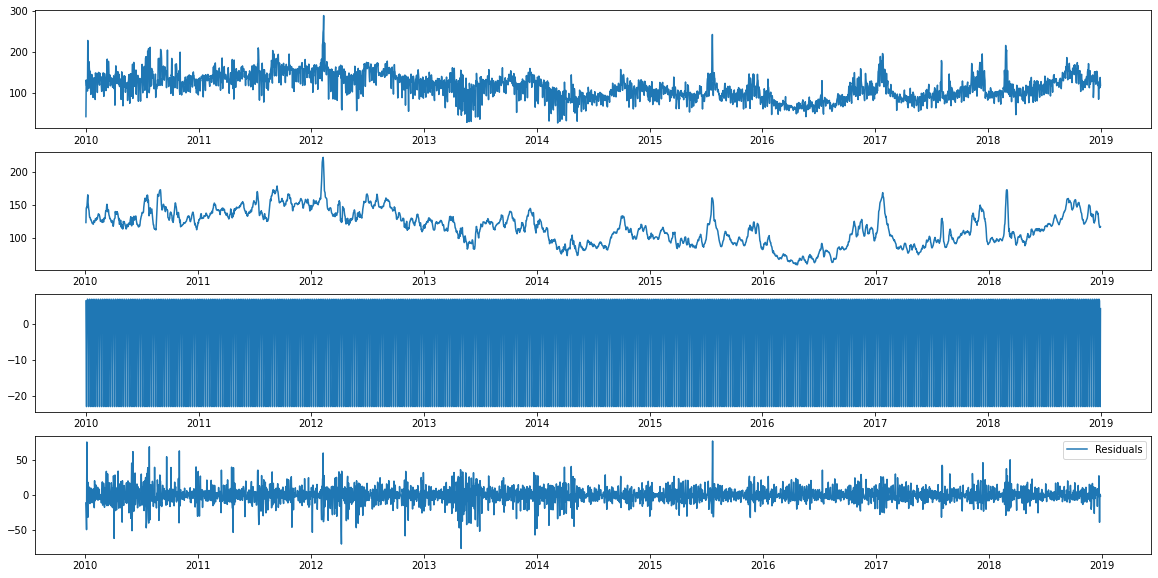

In [10]:
decomposition = seasonal_decompose(df)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4, figsize=(20,10))
axs[0].plot(df,label='Original')
plt.legend(loc='best')
axs[1].plot(trend, label='Trend')
plt.legend(loc='best')
axs[2].plot(seasonal, label='Seasonal')
plt.legend(loc='best')
axs[3].plot(residual, label='Residuals')
plt.legend(loc='best')

È possibile notare una forte stagioalità all'nterno dei dati. Come prima operazione viene calcolato il test di Deckey-Fuller per analizzare la stazionarietà della serie. Una time series è stazionaria se non è soggetta a trend o stagionalità. Dunque media e varianza sono costanti nel tempo.

Test di Deckey-Fuller:

*   Ipotesi nulla (H0): Se non è stata rifiutata, suggerisce che la serie temporale ha una radice unitaria, il che significa che non è stazionaria. Dunque, ha una struttura dipendente dal tempo.
*  Ipotesi alternativa (H1): L'ipotesi nulla viene rifiutata; suggerisce che la serie temporale non ha una radice unitaria, il che significa che è stazionaria. Dunque, non ha una struttura dipendente dal tempo.



In [11]:
from statsmodels.tsa.stattools import adfuller
X = df.value.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if result[1] < 0.05:
  print_bold("L'ipotesi nulla viene rifiutata")

ADF Statistic: -3.456585
p-value: 0.009175
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
L'ipotesi nulla viene rifiutata


L'ipotesi nulla viene rifiutata. Ciò significa che la serie temporale non ha una radice unitaria e può essere considerata stazionaria. Per questo motivo non è necessario apportare alcuna trasformazione alla serie.

### Divisione in Train e Validation

In [12]:
# Train fino al 31-12-2017
train = df[df.index <= ('2017-12-31')]
# Validation dal 01-01-2018 in poi
val = df[df.index > ('2017-12-31')]

In [13]:
print("Osservazioni Train: " + str(len(train)) + ' --> ' + str(round(len(train)/len(df) * 100,2)) + '%' )
print("Osservazioni Validation: " + str(len(val)) + ' --> ' + str(round(len(val)/len(df) * 100,2)) + '%' )

Osservazioni Train: 2922 --> 88.9%
Osservazioni Validation: 365 --> 11.1%


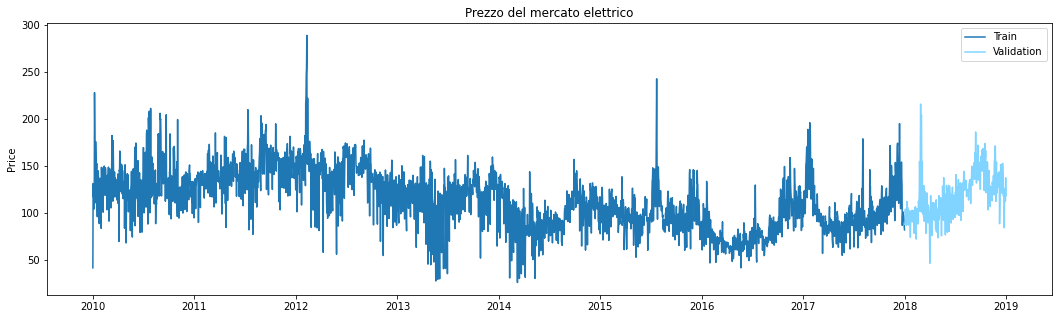

In [14]:
fig = plt.figure(figsize=(18,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Prezzo del mercato elettrico')
ax.plot(train, label='Train')
ax.plot(val, color='#80d4ff', label='Validation')
plt.ylabel('Price')
plt.legend()
plt.show()

## Arima

**Definizione funzioni**

Vengono di seguito definite alcune funzioni utili allo svolgimento del task

In [18]:
# Dunzione definizione e fit del modello SARIMAX:
def SARIMAX_def(data, p = 0, d = 0, q = 0, P = 0, D = 0, Q = 0, s = 0):
  # definizione modello
  model = sm.tsa.statespace.SARIMAX(data,
                                    order = (p, d, q),
                                    seasonal_order = (P, D, Q, s),
                                    enforce_stationarity = False,
                                    enforce_invertibility =False)
  # fit del modello
  model = model.fit(disp=False)

  return model

# Funzione plot ACF-PACF per il modello
def ACF_PACF(data):
  '''
    Plot dei grafici ACF e PACF
  '''

  # se data è un modello SARIMAX vengono utilizzati i residui
  if isinstance(data, sarimax.SARIMAXResultsWrapper):
    data = data.resid

  plt.rcParams.update({'figure.figsize':(22,5)})
  fig, axes = plt.subplots(1, 2, sharex=True)
  plot_acf(data, ax=axes[0], lags = 40) # ACF
  axes[0].set_title('ACF')
  plot_pacf(data, ax=axes[1], lags = 40) # PACF
  axes[1].set_title('PACF')
  plt.show()

Visualizzazione dei grafici **ACF** e **PACF** per l'intera time series

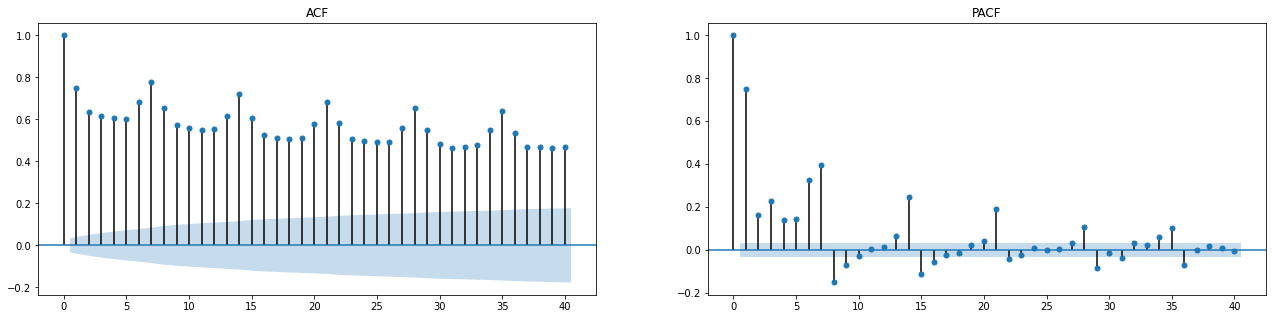

In [19]:
ACF_PACF(df)

Come ci si aspettava è possibile osservare la presenza di componenti stagionali. In particolare è possibile osservare una componente stagionale ogni sette giorni.

Viene quindi analizzato il modello **$SARIMA(1,1,1)_7$**.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                            Statespace Model Results                           
Dep. Variable:                   value   No. Observations:                 2922
Model:             SARIMAX(1, 1, 0, 7)   Log Likelihood              -12675.938
Date:                 Fri, 28 Aug 2020   AIC                          25355.877
Time:                         07:40:12   BIC                          25367.832
Sample:                     01-01-2010   HQIC                         25360.183
                          - 12-31-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.3682      0.011    -32.507      0.000      -0.390      -0.346
sigma2       350.3089      5.440     64.394      0.000     339.647     360.971
Ljung-Box (Q):                     1391.72  

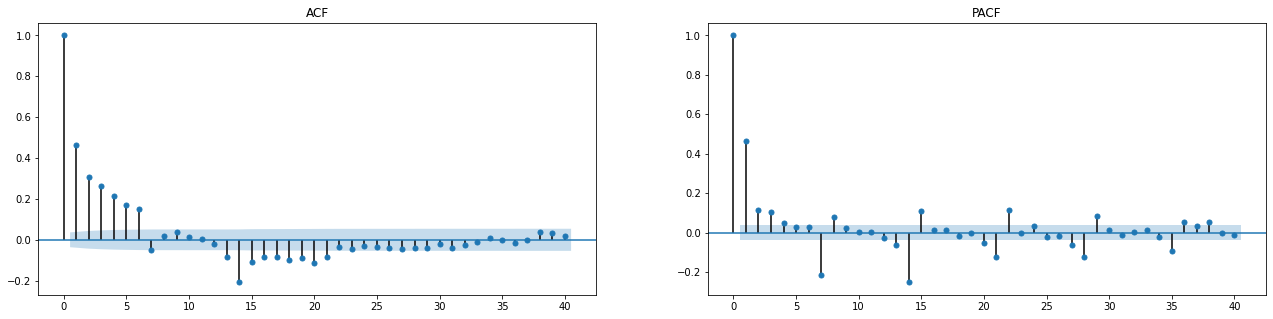

In [47]:
# SARIMA(1,0,1)_7
model = SARIMAX_def(train, p = 0, d = 0, q = 0, P = 1, D = 1, Q = 1, s = 7)
print(model.summary())

# Grafici ACF e PACF dei residui
ACF_PACF(model)

L'integrazione stagionale è stata risolta. Dai grafici ACF e PACF, si può notare la presenza di un modello ARMA ma i coefficienti non sono ben identificabili (si potrebbe ipotizzare un MA(6)). Per questo motivo viene utilizzata la tecnica del **greed search** finalizzata a massimizzare la log-likelihood per trovare i giusti valori p e q per AR(p) ed MA(q).

In [19]:
'''best_log = -999999
for p in tqdm_notebook(range(8)):
  for q in range(8):
    # creazione del modello e fitting
    model = SARIMAX_def(train, p = p, d = 0, q = q, P = 1, D = 1, Q = 1, s = 7)
    # salvataggio della log-likelihood del modello
    log = model.llf
    # controllo della log-likelihood maggiore
    if log >= best_log:
      best_log = log
      params = ((p,q))
    print('Testing AR {} - MA {} //// Best log-likelihood: {}, (BEST ARMA {})'.format(p, q, round(best_log, 2), params))

print('----------------------------------------------------------------------------')
print()
print()
print_bold('BEST AR {} - MA {},  with log-likelihood: {}'.format(params[0], params[1], best_log))'''

"best_log = -999999\nfor p in tqdm_notebook(range(8)):\n  for q in range(8):\n    # creazione del modello e fitting\n    model = SARIMAX_def(train, p = p, d = 0, q = q, P = 1, D = 1, Q = 1, s = 7)\n    # salvataggio della log-likelihood del modello\n    log = model.llf\n    # controllo della log-likelihood maggiore\n    if log >= best_log:\n      best_log = log\n      params = ((p,q))\n    print('Testing AR {} - MA {} //// Best log-likelihood: {}, (BEST ARMA {})'.format(p, q, round(best_log, 2), params))\n\nprint('----------------------------------------------------------------------------')\nprint()\nprint()\nprint_bold('BEST AR {} - MA {},  with log-likelihood: {}'.format(params[0], params[1], best_log))"

Viene addestrato il miglior modello trovato attraverso l'utilizzo di greed search

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 0, 7)x(1, 1, 1, 7)   Log Likelihood              -11955.728
Date:                           Fri, 28 Aug 2020   AIC                          23943.457
Time:                                   08:50:40   BIC                          24039.099
Sample:                               01-01-2010   HQIC                         23977.909
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3957      0.015     27.075      0.000       0.367       0.424
ar.L2          0.0491      0.017      2.852

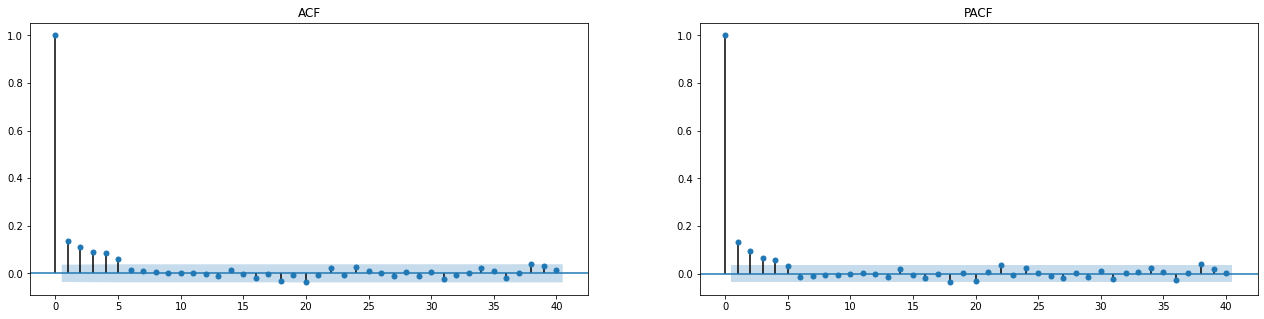

In [101]:
params = ((6,7))
p = params[0]
q = params[1]
best_model = SARIMAX_def(train, p = p, d = 0, q = q, P = 1, D = 1, Q = 1, s = 7)
print(best_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(best_model)

Dopo aver trovati i mgliori valori per i modelli AR ed MA avvero ARMA(6,6) viene testato il modello ARIMA(6,1,6)

In [ ]:
best_model = SARIMAX_def(train, p = p, d = 1, q = q, P = 1, D = 1, Q = 1, s = 7)
print(best_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(best_model)

È possibile osservare come i residui siano rientrati nella banda tranne un unico residuo a 20.

In [ ]:
predicted_val = best_model.get_prediction(start=val.index[0], end=val.index[-1])
predicted_val_mean = predicted_val.predicted_mean

plt.plot(df)
plt.plot(predicted_val_mean, color='green')

In [ ]:
import matplotlib.dates as mdates
plt.plot(predicted_val_mean, color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()

Sembra continuare ad esserci una stagionalità ogni 20 giorni

### Multistagionalità

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [98]:
# prepare Fourier terms
exog = pd.DataFrame({'date': df.index})
exog = exog.set_index(df.index)
exog['sin365'] = np.sin(2*np.pi*exog.index.day / 365.25)
exog['cos365'] = np.cos(2*np.pi*exog.index.day / 365.25)
# Train fino al 31-12-2017
exog_train = exog[exog.index <= ('2017-12-31')]
exog_train = exog_train.drop(columns=['date'])
# Validation dal 01-01-2018 in poi
exog_val = exog[exog.index > ('2017-12-31')]
exog_val = exog_val.drop(columns=['date'])

# crate model
exog_model = sm.tsa.statespace.SARIMAX(train['value'],
                                       order = (6, 1, 6),
                                       seasonal_order = (1, 1, 1, 7),
                                       exog = exog_train,
                                       enforce_stationarity = False,
                                       enforce_invertibility =False)
  
# fit model
exog_model = exog_model.fit(disp=False)
print(exog_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 6)x(1, 1, 1, 7)   Log Likelihood              -11855.739
Date:                           Fri, 28 Aug 2020   AIC                          23745.478
Time:                                   08:47:56   BIC                          23847.010
Sample:                               01-01-2010   HQIC                         23782.062
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365        29.0485     12.358      2.351      0.019       4.828      53.269
cos365        80.0689     45.173      1.772

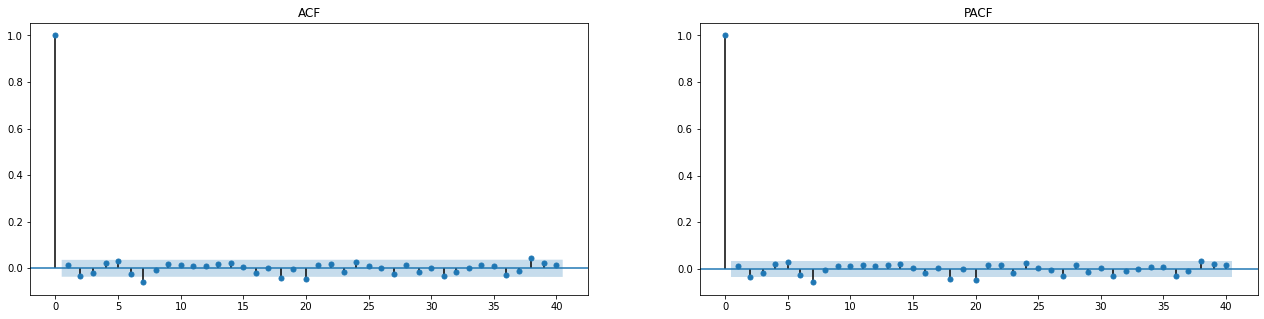

In [99]:
# plot ACF e PACF dei residui del modello
ACF_PACF(exog_model)

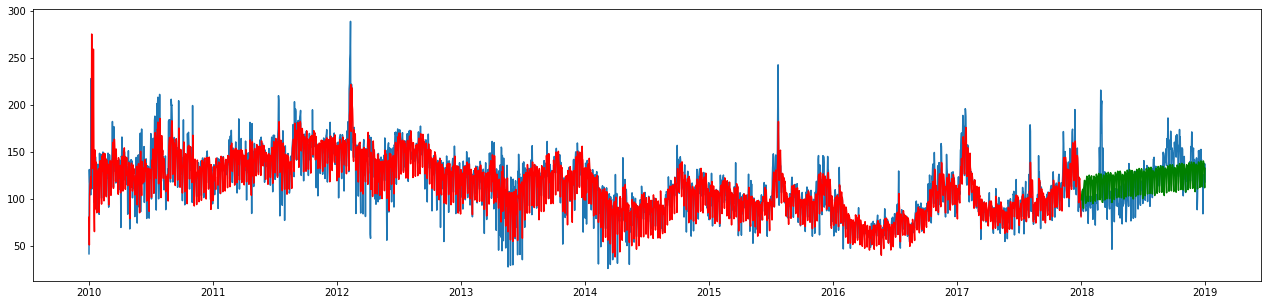

In [100]:
predicted_train = exog_model.get_prediction(start = train.index[0], end = train.index[-1], exog = exog_train)
predicted_train_mean = predicted_train.predicted_mean

predicted_val = exog_model.get_prediction(start=val.index[0], end=val.index[-1], exog = exog_val)
predicted_val_mean = predicted_val.predicted_mean

plt.plot(df)
plt.plot(predicted_train_mean, color='red')
plt.plot(predicted_val_mean, color='green')

### Regressori Holiday

Considerando che si tratta di una serie temporale rappresentate il consumo di energia elettrica può essere utile utilizzare dei regressori esterni per monitorare i diversi eventi come le feste.

In [90]:
# aggiunta delle festività al Dataset
holiday_date = []
holiday_name = []
for h in tqdm_notebook(holidays.Italy(years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]).items()): 
    holiday_date.append(h[0])
    holiday_name.append(h[1])
  
holiday_df = pd.DataFrame(data=holiday_name, index=holiday_date)
temp = pd.concat((df, holiday_df), axis=1)
df_dummy = pd.get_dummies(temp)
df_dummy = df_dummy.set_index(df.index)
df_dummy = df_dummy.drop('value', axis = 1)

# Train fino al 31-12-2017
train_dummy = df_dummy[df_dummy.index <= ('2017-12-31')]
print('Dimensioni train:', train_dummy.shape)
# Validation dal 01-01-2018 in poi
val_dummy = df_dummy[df_dummy.index > ('2017-12-31')]
print('Dimensioni validation:', val_dummy.shape)

df_dummy.head()


Dimensioni train: (2922, 13)
Dimensioni validation: (365, 13)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,"0_Festa della Liberazione, Lunedì dell'Angelo",0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
Data,,,,,,,,,,,,,
2010-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
# crate model
exog_model = sm.tsa.statespace.SARIMAX(train['value'],
                                       order = (6, 1, 6),
                                       seasonal_order = (1, 1, 1, 7),
                                       exog = train_dummy,
                                       enforce_stationarity = False,
                                       enforce_invertibility =False)
  
# fit model
exog_model = exog_model.fit(disp=False)
print(exog_model.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 6)x(1, 1, 1, 7)   Log Likelihood              -11851.972
Date:                           Fri, 28 Aug 2020   AIC                          23759.945
Time:                                   08:36:05   BIC                          23927.174
Sample:                               01-01-2010   HQIC                         23820.201
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
0_Assunzione della Vergine                        0.

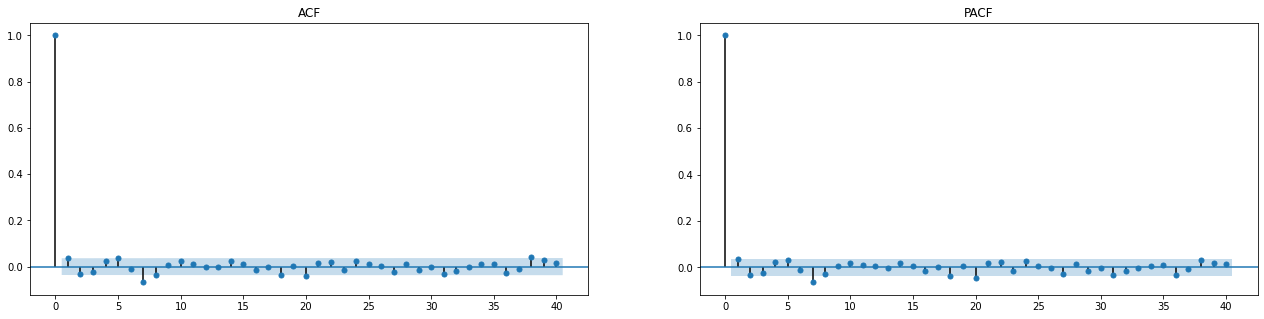

In [92]:
# plot ACF e PACF dei residui del modello
ACF_PACF(exog_model)

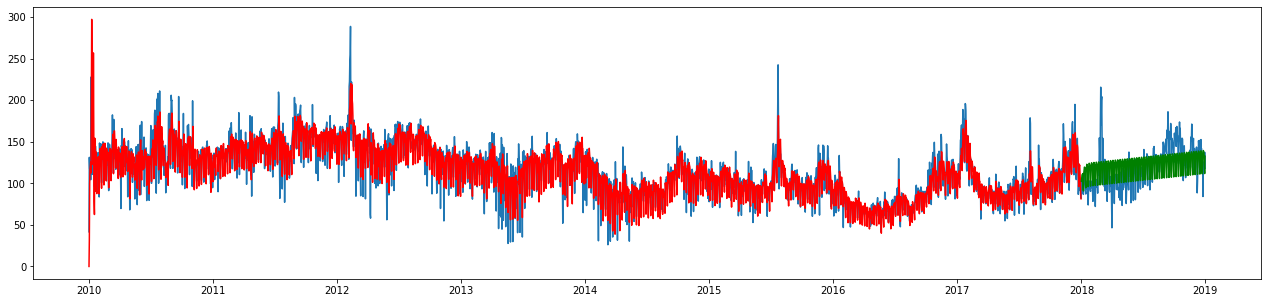

In [93]:
predicted_train = exog_model.get_prediction(start = train.index[0], end = train.index[-1], exog = train_dummy)
predicted_train_mean = predicted_train.predicted_mean

predicted_val = exog_model.get_prediction(start=val.index[0], end=val.index[-1], exog = val_dummy)
predicted_val_mean = predicted_val.predicted_mean

plt.plot(df)
plt.plot(predicted_train_mean, color='red')
plt.plot(predicted_val_mean, color='green')

### Multistagionalità + Holiday